In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis, get_time_plate_info_long_from_analysis
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
logging.getLogger().setLevel(logging.WARNING)

all_analysis_folders = get_analysis_folders()
#for P
plates = [
"416_20230705",
"427_20230707",
"420_20230705",
"431_20230627",
"474_20230807",
"460_20230807",
"464_20230807",
"440_20230723",
"436_20230717",
"443_20230720",
"439_20230804",
"470_20230709",
'478_20230814', '468_20230809', '447_20230821', '487_20230922',
       '492_20230901', '471_20230821', '486_20231009',
       '494_20230908', '482_20230908', '495_20231013', '463_20231013',
       '491_20231013', '481_20231005', '483_20231005',
    '490_20231003',
       '485_20230929',
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
len(plates)

28

In [3]:
all_analysis_folders['medium'].unique()

array(["'0Myr'", "'001P100N100C'", "'GR24'", "'0.5Myr'", "'001P100N200C'",
       "'001P100N'", "'control'", "'5DS'", "'Myr'", "'MSR'", "'1Myr'",
       "'001P100N200C-T'", "'001P100N100C-T'"], dtype=object)

In [4]:
# folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
folders,time_plate_info = get_time_plate_info_long_from_analysis(analysis_folders,False)
time_plate_info['unique_id'] = time_plate_info['unique_id'].replace(47020230709,47020230802)
time_plate_info=time_plate_info[time_plate_info['Plate']!=431]
# time_plate_info['time_since_begin_hour'] = time_plate_info['time_since_begin_h'].dt.total_seconds() / 3600.0
# time_plate_info['time_since_begin_hour'] = time_plate_info['time_since_begin_h']

In [5]:
import pandas as pd

# Assuming df is your DataFrame
columns_to_check = [f'SA_region_{i}' for i in range(18)] + [f'length_density_region_{i}' for i in range(18)]

# Filter DataFrame rows where any of the specified columns have NaN values
df_filtered = time_plate_info[time_plate_info[columns_to_check].isna().any(axis=1)]

# Find the unique ids corresponding to those rows
unique_ids_with_nans = df_filtered['unique_id'].unique()

print("Unique IDs with at least one NaN in specified columns:", unique_ids_with_nans)


Unique IDs with at least one NaN in specified columns: [47420230807]


In [6]:
[plate for plate in plates if int(plate) not in time_plate_info['unique_id'].unique()]

['431_20230627',
 '470_20230709',
 '495_20231013',
 '463_20231013',
 '491_20231013']

In [7]:
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df['time_since_begin_hour'] = df['time_since_begin_h'].dt.total_seconds() / 3600.0
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)

In [8]:
for i in range(18):
    calculate_integral(time_plate_info,f'SA_region_{i}',f'integrated_SA_{i}')
for i in range(18):
    calculate_integral(time_plate_info,f'length_density_region_{i}',f'integrated_L_{i}')


In [9]:
coarse_to_basic_mapping = {
    1: [1, 2],
    2: [3, 8],
    3: [4, 5],
    4: [6, 7],
    5: [9, 10],
    6: [11, 12],
    7: [13],
    8: [14, 15],
    9: [16, 17, 18]
}

# Mapping for "simple" to "basic"
simple_to_basic_mapping = {
    0: list(range(1, 11)),
    1: list(range(11, 19))
}
sub_to_basic_mapping = {
    0: list(range(1, 19)),
}

In [10]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from helper import *
from amftrack.notebooks.P_experiment.helper import get_polygons
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')

%matplotlib widget
C_max2 = 1.53

def fit_function(x, C_max):
    return 1+C_max * 1/x**(3/2)
# Read the Excel file
path = r'C:\Users\coren\Documents\PhD\Pexperiment'
path_excel = os.path.join(path,'summary.xlsx')
df = pd.read_excel(path_excel)
df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day_sample'] = pd.to_datetime(df['day_sample'], format='%Y%m%d')  # Update the format as necessary
df['day_start'] = pd.to_datetime(df['start'], format='%Y%m%d')  # Update the format as necessary

df['time_elapsed'] = df['day_sample'] - df['day_start']
df['time_elapsed_day'] = df['time_elapsed'].dt.days
df['time_since_crossing'] = df['day_sample'] - df['date_from_unique_id']
df['t2 (day)'] = df['time_since_crossing'].dt.days
df['t1 (day)'] = df['time_elapsed_day']-df['t2 (day)']
df['treatment'] = df['treatment'].fillna('none')
df['wet_weight_measured'] = df['wet weight']

df['wet weight'] = df['wet weight']-df['lost weight']
df['totP (ug)'] = df['totP (ug)'] * fit_function(df['totP (ug)'], C_max2)
df['Sample_name'] = df['Sample_name'].str.replace('bottom','0')
df['Sample_name'] = df['Sample_name'].str.replace('up','1')
df['Sample_name'] = df['Sample_name'].str.replace('top','1')
df['Sample_name'] = df['Sample_name'].str.replace('agar','0')



df = df.loc[df['plate']!=487]
df = df.loc[df['type'] == 'agar']
df['pos'] = df['Sample_name'].str.split('-').str.get(1).astype(int)

time_plate_info.sort_values(['unique_id', 'time_since_begin_h'], inplace=True)

# Group by unique_id and take the last entry for each group
last_values = time_plate_info.groupby('unique_id').last().reset_index()

# Create a function to map 'pos' to the corresponding integrated_Ldens_i value
def get_integrated_density(row):
    unique_id = row['unique_id']
    pos = row['pos']
    arrangement = row['arrangement']
    if arrangement == 'basic':
        col_names = [f'integrated_SA_{pos-1}']
    if arrangement == 'simple':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in simple_to_basic_mapping[pos]]
    if arrangement == 'coarse':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in coarse_to_basic_mapping[pos]] 
    if arrangement == 'sub':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in sub_to_basic_mapping[pos]] 
    if not unique_id is np.nan:
        last_value_row = last_values[last_values['unique_id'] == int(unique_id)]
        return np.sum(last_value_row[col_names].values) if not last_value_row.empty else None
    else:
        return(None)
df['integrated_SA'] = df.apply(get_integrated_density, axis=1)

grouped = df.groupby(['plate', 'type', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum',
    'integrated_SA':"sum"
}).reset_index()

# Rename columns
grouped.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped.columns]
grouped = grouped.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6

df['C_P'] = df['totP (ug)'] / df['wet weight']
df['P_content'] = df['totP (ug)'] / df['dry weight']/1e6
# df = df[df['type'] != 'sub']

grouped = grouped[grouped['plate']!=487]

df['integrated_SA_C']=df['integrated_SA']/df['wet weight']
# grouped = dfgrouped = df.groupby(['plate', 'type',"time_elapsed_day","t1 (day)","treatment",'t2 (day)']).agg({'totP (ug)': 'sum', 'wet weight': 'sum','dry weight' : "sum",'integrated_SA':"sum"}).reset_index()
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6
grouped['integrated_SA_C']=grouped['integrated_SA']/grouped['tot_wet_weight']
tot_weights = grouped[grouped['type'].isin(["agartot", "rootagartot"])].set_index(['plate', 'type'])['wet_weight_measured'].to_dict()

# Function to determine the 'measured_tot_wet_weight' based on conditions
def get_tot_weight(row):
    if row['type'] == 'agar' and (row['plate'], 'agartot') in tot_weights:
        return tot_weights[(row['plate'], 'agartot')]
    elif row['type'] == 'rootagar' and (row['plate'], 'rootagartot') in tot_weights:
        return tot_weights[(row['plate'], 'rootagartot')]
    else:
        return row['wet_weight_measured']

# Apply the function to get 'measured_tot_wet_weight' column
grouped['measured_tot_wet_weight'] = grouped.apply(get_tot_weight, axis=1)
grouped= grouped[grouped['type'] != 'rootagartot']
grouped= grouped[grouped['type'] != 'agartot']
# Step 1: Identify plates that don't have any rows with type "agartot"
plates_with_agartot = grouped[grouped['type'] == 'rootagartot']['plate'].unique()
valid_plates = grouped[~grouped['plate'].isin(plates_with_agartot)]

# Step 2: Compute the average "wet weight" for type 'agar' and 'rootagar'
average_wet_weight_agar = valid_plates[valid_plates['type'] == 'agar']['measured_tot_wet_weight'].mean()
average_wet_weight_rootagar = valid_plates[valid_plates['type'] == 'rootagar']['measured_tot_wet_weight'].mean()

# Step 3: Replace rows in the 'average weight' column accordingly
grouped['average weight'] = None  # Initialize column with None values
grouped.loc[grouped['type'] == 'agar', 'average weight'] = average_wet_weight_agar
grouped.loc[grouped['type'] == 'rootagar', 'average weight'] = average_wet_weight_rootagar
grouped.loc[grouped['type'] == 'agar', 'fullP'] = grouped.loc[grouped['type'] == 'agar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'agar', 'C_P']
grouped.loc[grouped['type'] == 'rootagar', 'fullP'] = grouped.loc[grouped['type'] == 'rootagar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'rootagar', 'C_P']
grouped.loc[grouped['type'] == 'root', 'fullP'] = grouped.loc[grouped['type'] == 'root', 'totP (ug)']
totP_theory = 100
grouped['scaling_factor'] = totP_theory/grouped.groupby('plate')['fullP'].transform('sum')

# Multiply 'fullP' by the scaling factor to get 'fullP_rescaled'
grouped['fullP_rescaled'] = grouped['fullP'] * grouped['scaling_factor']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


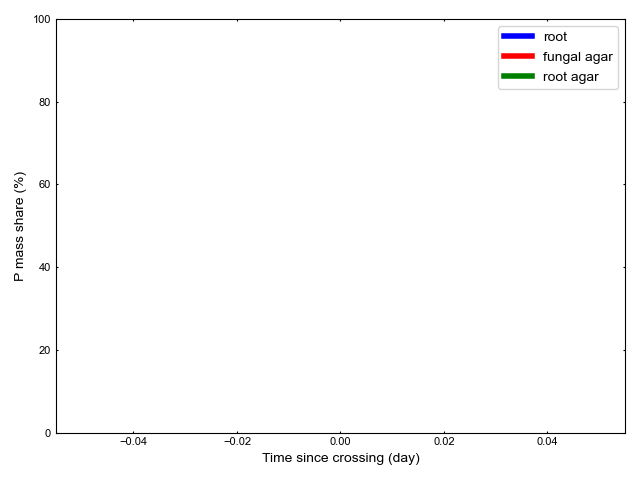

In [11]:
from matplotlib.lines import Line2D
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='100P']
select = select[select['plate']!=431]
select = select[select['plate']!=487]

t2_values = select['t2 (day)'].unique()
color_dict = {
    'root': 'blue',
    'agar': 'red',
    'rootagar': 'green'
}
# Plotting
fig, ax = plt.subplots()
blues = []
reds = []
greens = []
t2s = []
for t2 in sorted(t2_values):
    plate_data = select[select['t2 (day)'] == t2]
    
    bottom = 0
    k=0
    for type_ in ['root', 'agar', 'rootagar']:
        value = plate_data[plate_data['type'] == type_]['fullP_rescaled'].mean()
            # print(t2,plate_data[plate_data['type'] == type_]['plate'])
        ax.bar(t2, value, bottom=bottom, color=color_dict[type_])
        bottom += value
   
        if k==0:
            blues.append(bottom)
        elif k==1:
            reds.append(bottom)
        else:
            greens.append(bottom)
        k+=1
    t2s.append(t2)
ax.fill_between(t2s,blues,color="blue",alpha = 0.3)
ax.fill_between(t2s,blues,reds,color="red",alpha = 0.3)
ax.fill_between(t2s,greens,reds,color="green",alpha = 0.3)

# Setting labels and title
ax.set_ylabel('fullP Value')
ax.set_xlabel('t2 Value')
ax.set_ylim(0,100)
color_dict = {
    'root': 'blue',
    'fungal agar': 'red',
    'root agar': 'green'
}
legend_elements = [Line2D([0], [0], color=color_dict[type_], lw=4, label=type_) for type_ in color_dict.keys()]
ax.legend(handles=legend_elements)
ax.set_ylabel('P mass share (%)')
ax.set_xlabel('Time since crossing (day)')
plt.tight_layout()

In [12]:
def set_r_value(row):
    if row['arrangement'] == 'basic':
        if 1 <= row['pos'] <= 5:
            return 0
        elif 6 <= row['pos'] <= 10:
            return 1
        elif 11 <= row['pos'] <= 15:
            return 2
        elif 16 <= row['pos'] <= 18:
            return 3
    elif row['arrangement'] == 'coarse':
        if 1 <= row['pos'] <= 3:
            return 0
        elif 4 <= row['pos'] <= 5:
            return 1
        elif 6 <= row['pos'] <= 8:
            return 2
        elif row['pos'] == 9:
            return 3
    elif row['arrangement'] == 'simple':
        if row['pos'] == 0:
            return 0.5
        elif row['pos'] == 1:
            return 2.5
    return None  # Default case if none of the conditions are met

# Apply the function to the DataFrame
df['r_value'] = df.apply(set_r_value, axis=1)
grouped_r = df.groupby(['plate', 'type', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start","r_value"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum',
    'integrated_SA':"sum"
}).reset_index()

# Rename columns
grouped_r.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped_r.columns]
grouped_r = grouped_r.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped_r['C_P'] = grouped_r['totP (ug)'] / grouped_r['tot_wet_weight']


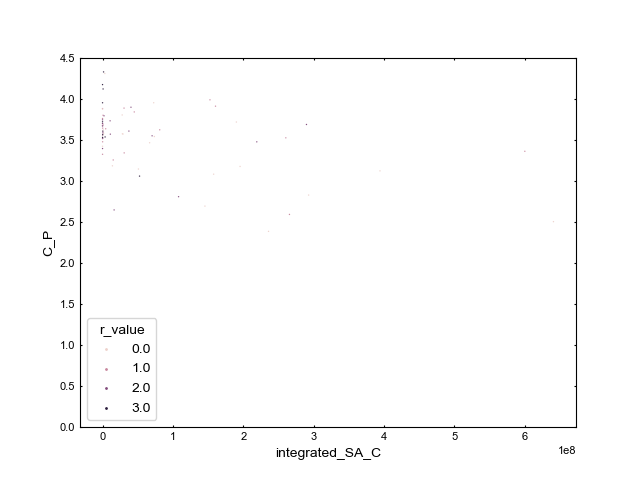

In [13]:
fig,ax = plt.subplots()
df = df[df['plate']!=431]
select = df[df['treatment']=='100P']
select = select[select['t2 (day)']<=9]
select = select[select['arrangement'].isin(['coarse','basic'])]


sns.scatterplot(select,x = 'integrated_SA_C',y = 'C_P',ax = ax,hue ="r_value")
# ax.set_xscale('log')
# ax.hlines(mean0P,0,2e9, color = "grey",label = "test samples (0P)")
ax.set_ylim(0,4.5)
plt.show()

In [14]:
grouped_r['t2_coarse'] = grouped_r['t2 (day)']//3*3

grouped_r['rvalue_coarse'] = grouped_r['r_value']//2*2*2*10
grouped_r['C_P_0'] = grouped_r['C_P']-2
grouped_r['time (day)'] = grouped_r['t2_coarse'].apply(lambda x: 9 if x >= 9 else x)

# Creating the plot


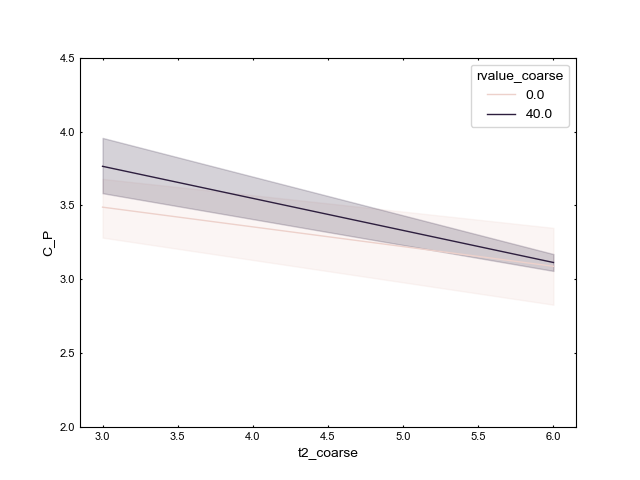

In [15]:
fig,ax = plt.subplots()
df = grouped_r[grouped_r['plate']!=431]
select = grouped_r[grouped_r['treatment']=='100P']
select = select[select['t2 (day)']<=9]
select = select[select['C_P']<=5]

select = select[select['arrangement'].isin(['coarse','basic'])]


# sns.scatterplot(select,x = 't2 (day)',y = 'C_P',ax = ax,hue ="r_value")
sns.lineplot(select,x = 't2_coarse',y = 'C_P',ax = ax,hue ="rvalue_coarse",estimator = "mean")
# sns.lmplot(select,x = 't2 (day)',y = 'C_P',hue ="r_value")

# ax.set_xscale('log')
# ax.hlines(mean0P,0,2e9, color = "grey",label = "test samples (0P)")
ax.set_ylim(2,4.5)
plt.show()

2024-05-15 16:26:28,197-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


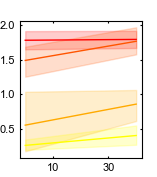

In [21]:
path_figure = r'C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\HFSP_symbiotic-networks\\Article_TravellingWave\\Supplementary material\\extended_data_figures'

cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (4*cm,4.5*cm))
select = grouped_r[grouped_r['treatment']=='100P']
select = select[select['t2 (day)']<=30]
select = select[select['C_P']<=5]

select = select[select['arrangement'].isin(['coarse','basic','simple'])]
# select = select[select['arrangement'].isin(['coarse','basic'])]


# Creating the plot


# sns.scatterplot(select,x = 'r_value',y = 'C_P',ax = ax,hue ="t2 (day)")
sns.lineplot(select,x = 'rvalue_coarse',y = 'C_P_0',ax = ax,hue ="time (day)",estimator = "mean",palette="autumn",legend=False)
ax.set_xticks([10, 30])
ax.set_xlabel('$r$ ($mm$)')
ax.set_ylabel('$[P]$ ($\mu g/ mL$)')
plt.savefig(os.path.join(path_figure,f'FigurespatialP.pdf'), transparent=True, bbox_inches='tight')
# plt.show()

In [17]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from helper import *
from amftrack.notebooks.P_experiment.helper import get_polygons
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')

%matplotlib widget
C_max2 = 1.53

def fit_function(x, C_max):
    return 1+C_max * 1/x**(3/2)
# Read the Excel file
path = r'C:\Users\coren\Documents\PhD\Pexperiment'
path_excel = os.path.join(path,'summary.xlsx')
df = pd.read_excel(path_excel)
df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day_sample'] = pd.to_datetime(df['day_sample'], format='%Y%m%d')  # Update the format as necessary
df['day_start'] = pd.to_datetime(df['start'], format='%Y%m%d')  # Update the format as necessary

df['time_elapsed'] = df['day_sample'] - df['day_start']
df['time_elapsed_day'] = df['time_elapsed'].dt.days
df['time_since_crossing'] = df['day_sample'] - df['date_from_unique_id']
df['t2 (day)'] = df['time_since_crossing'].dt.days
df['t1 (day)'] = df['time_elapsed_day']-df['t2 (day)']
df['treatment'] = df['treatment'].fillna('none')
df['wet_weight_measured'] = df['wet weight']

df['wet weight'] = df['wet weight']-df['lost weight']
df['totP (ug)'] = df['totP (ug)'] * fit_function(df['totP (ug)'], C_max2)
df['Sample_name'] = df['Sample_name'].str.replace('bottom','0')
df['Sample_name'] = df['Sample_name'].str.replace('up','1')
df['Sample_name'] = df['Sample_name'].str.replace('top','1')
df['Sample_name'] = df['Sample_name'].str.replace('agar','0')



df = df.loc[df['plate']!=487]

time_plate_info.sort_values(['unique_id', 'time_since_begin_h'], inplace=True)

# Group by unique_id and take the last entry for each group
last_values = time_plate_info.groupby('unique_id').last().reset_index()


grouped = df.groupby(['plate', 'type', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum',
}).reset_index()

# Rename columns
grouped.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped.columns]
grouped = grouped.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6

df['C_P'] = df['totP (ug)'] / df['wet weight']
df['P_content'] = df['totP (ug)'] / df['dry weight']/1e6
# df = df[df['type'] != 'sub']

grouped = grouped[grouped['plate']!=487]

# df['integrated_SA_C']=df['integrated_SA']/df['wet weight']
# grouped = dfgrouped = df.groupby(['plate', 'type',"time_elapsed_day","t1 (day)","treatment",'t2 (day)']).agg({'totP (ug)': 'sum', 'wet weight': 'sum','dry weight' : "sum",'integrated_SA':"sum"}).reset_index()
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6
tot_weights = grouped[grouped['type'].isin(["agartot", "rootagartot"])].set_index(['plate', 'type'])['wet_weight_measured'].to_dict()

# Function to determine the 'measured_tot_wet_weight' based on conditions
def get_tot_weight(row):
    if row['type'] == 'agar' and (row['plate'], 'agartot') in tot_weights:
        return tot_weights[(row['plate'], 'agartot')]
    elif row['type'] == 'rootagar' and (row['plate'], 'rootagartot') in tot_weights:
        return tot_weights[(row['plate'], 'rootagartot')]
    else:
        return row['wet_weight_measured']

# Apply the function to get 'measured_tot_wet_weight' column
grouped['measured_tot_wet_weight'] = grouped.apply(get_tot_weight, axis=1)
# Step 1: Identify plates that don't have any rows with type "agartot"
plates_with_agartot = grouped[grouped['type'] == 'rootagartot']['plate'].unique()
valid_plates = grouped[~grouped['plate'].isin(plates_with_agartot)]

# Step 2: Compute the average "wet weight" for type 'agar' and 'rootagar'
average_wet_weight_agar = valid_plates[valid_plates['type'] == 'agar']['measured_tot_wet_weight'].mean()
average_wet_weight_rootagar = valid_plates[valid_plates['type'] == 'rootagar']['measured_tot_wet_weight'].mean()

# Step 3: Replace rows in the 'average weight' column accordingly
grouped['average weight'] = None  # Initialize column with None values
grouped.loc[grouped['type'] == 'agar', 'average weight'] = average_wet_weight_agar
grouped.loc[grouped['type'] == 'rootagar', 'average weight'] = average_wet_weight_rootagar
grouped.loc[grouped['type'] == 'agar', 'fullP'] = grouped.loc[grouped['type'] == 'agar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'agar', 'C_P']
grouped.loc[grouped['type'] == 'rootagar', 'fullP'] = grouped.loc[grouped['type'] == 'rootagar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'rootagar', 'C_P']
grouped.loc[grouped['type'] == 'root', 'fullP'] = grouped.loc[grouped['type'] == 'root', 'totP (ug)']
totP_theory = 100
grouped['scaling_factor'] = totP_theory/grouped.groupby('plate')['fullP'].transform('sum')

# Multiply 'fullP' by the scaling factor to get 'fullP_rescaled'
grouped['fullP_rescaled'] = grouped['fullP'] * grouped['scaling_factor']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


agar 0.7155728225338454
root 0.4487471204532693
2024-05-15 16:26:00,283-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


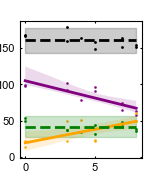

In [20]:
path_figure = r'C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\HFSP_symbiotic-networks\\Article_TravellingWave\\Supplementary material\\extended_data_figures'
# plt.style.use('presentation2.mplstyle')
from matplotlib.lines import Line2D
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='100P']
select = select[select['t2 (day)']<=9]
select = select[select['plate']!=431]
select = select[select['plate']!=487]
column = 't2 (day)'
t2_values = select[column].unique()
color_dict = {
    'root': 'blue',
    'agar': 'red',
    'rootagar': 'green'
}
width = 1
height = 1.5

fig,ax = plt.subplots(figsize = (4*cm,4.5*cm))
# Unique categories in the hue column
types = select['type'].unique()
color_dict = {
    'root': 'orange',
    'agar': 'purple',
    'rootagar': 'green'
}

# Iterate over each category
for type_obj in types:
    # Subset data for the category
    subset = select[select['type'] == type_obj]
    if type_obj == "rootagar":
        ax.scatter(subset[column], subset['fullP'], color=color_dict[type_obj])
        line_style = {"linestyle": "--","linewidth":4}  # Dashed line for 'rootagar'
        mean_value = subset['fullP'].mean()
        std_value = subset['fullP'].std()
        xmin = np.min(subset[column])
        xmax = np.max(subset[column])
        ax.hlines(y=mean_value, xmin = xmin,xmax = xmax, color=color_dict[type_obj], linestyle='--', linewidth = 2)
        ax.fill_between([xmin,xmax], mean_value - 2*std_value, mean_value + 2*std_value, color=color_dict[type_obj], alpha=0.2)
    else:
        line_style = {"linewidth":2}  # Default line style for other types

    # Create a regplot for the subset with customized line style for 'rootagar'
        sns.regplot(x=subset[column], y=subset['fullP'], color=color_dict[type_obj], line_kws=line_style)
        slope2, intercept, r_value, p_value, std_err = stats.linregress(subset[column], subset['fullP'])
    
        print(type_obj,r_value**2)
# for t2 in sorted(t2_values):
#     plate_data = select[select[column] == t2]
#     for k,type_ in enumerate(['root', 'agar', 'rootagar']):
#         value = plate_data[plate_data['type'] == type_]['fullP'].mean()
#             # print(t2,plate_data[plate_data['type'] == type_]['plate'])
#         ax.scatter(t2, value, color=color_dict[type_])
#         # print(t2,value,plate_data)
total = select.groupby("plate")
ax.scatter(total[column].mean(), total['fullP'].sum(), color="black")
mean_value = total['fullP'].sum().mean()
std_value = total['fullP'].sum().std()
ax.hlines(y=mean_value, xmin = np.min(total[column].mean()),xmax = np.max(total[column].mean()), color="black", linestyle='--', linewidth = 2)
ax.fill_between([xmin,xmax], mean_value - 2*std_value, mean_value + 2*std_value, color="black", alpha=0.2)
# sns.regplot(x=total[column].mean(), y=total['fullP'].sum(), color="black",
#                 scatter_kws={"s": 50}, line_kws=line_style)


# ax.set_ylabel('P mass (ug)')
ax.set_xlabel('t (day)')
ax.set_ylabel('$m_P$ ($\mu g$)')
plt.savefig(os.path.join(path_figure,'Figure_rebutal_Pdeplete.pdf'), transparent=True, bbox_inches='tight')
# path_figure = r"C:\Users\coren\Documents\PhD\paper\PandC\Fig3"
# plt.style.use('presentation.mplstyle')


agar 0.6950044456654599
root nan


C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\lib\function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


Text(0, 0.5, '$[P]$ ($\\mu g/ mL$)')

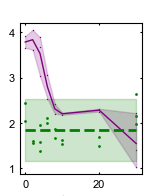

In [19]:
path_figure = r'C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\HFSP_symbiotic-networks\\Article_TravellingWave\\Supplementary material\\extended_data_figures'
# plt.style.use('presentation2.mplstyle')
grouped['day_grouped'] = grouped['t2 (day)'].apply(lambda x: x//2*2 if x<= 9 else x//10*10)

from matplotlib.lines import Line2D
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='100P']
select = select[select['t2 (day)']<=35]
select = select[select['plate']!=431]
select = select[select['plate']!=487]
column = 'day_grouped'
t2_values = select[column].unique()
color_dict = {
    'root': 'blue',
    'agar': 'red',
    'rootagar': 'green'
}
width = 1
height = 1.5

fig,ax = plt.subplots(figsize = (4*cm,5*cm))
# Unique categories in the hue column
types = select['type'].unique()
color_dict = {
    'root': 'orange',
    'agar': 'purple',
    'rootagar': 'green'
}

# Iterate over each category
for type_obj in types:
    # Subset data for the category
    subset = select[select['type'] == type_obj]
    if type_obj == "rootagar":
        ax.scatter(subset[column], subset['C_P'], color=color_dict[type_obj])
        line_style = {"linestyle": "--","linewidth":4}  # Dashed line for 'rootagar'
        mean_value = subset['C_P'].mean()
        std_value = subset['C_P'].std()
        xmin = np.min(subset[column])
        xmax = np.max(subset[column])
        ax.hlines(y=mean_value, xmin = xmin,xmax = xmax, color=color_dict[type_obj], linestyle='--', linewidth = 2)
        ax.fill_between([xmin,xmax], mean_value - 2*std_value, mean_value + 2*std_value, color=color_dict[type_obj], alpha=0.2)
    else:
        line_style = {"linewidth":2}  # Default line style for other types

    # Create a regplot for the subset with customized line style for 'rootagar'
        # sns.regplot(x=subset[column], y=subset['fullP'], color=color_dict[type_obj], line_kws=line_style)
        sns.scatterplot(x=subset[column], y=subset['C_P'], color=color_dict[type_obj])
        
        sns.lineplot(x=subset[column], y=subset['C_P'], color=color_dict[type_obj])
        
        slope2, intercept, r_value, p_value, std_err = stats.linregress(subset[column], subset['C_P'])
    
        print(type_obj,r_value**2)
# for t2 in sorted(t2_values):
#     plate_data = select[select[column] == t2]
#     for k,type_ in enumerate(['root', 'agar', 'rootagar']):
#         value = plate_data[plate_data['type'] == type_]['fullP'].mean()
#             # print(t2,plate_data[plate_data['type'] == type_]['plate'])
#         ax.scatter(t2, value, color=color_dict[type_])
#         # print(t2,value,plate_data)
total = select.groupby("plate")

# sns.regplot(x=total[column].mean(), y=total['fullP'].sum(), color="black",
#                 scatter_kws={"s": 50}, line_kws=line_style)


# ax.set_ylabel('P mass (ug)')
ax.set_xlabel('t (day)')
ax.set_ylabel('$[P]$ ($\mu g/ mL$)')

